In [1]:
import opendatasets as od
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set some constant variables

In [2]:
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

# Creation of some helper functions

In [3]:
def plot_random_image(dataset_dir, class_names):
    random_class = random.choice(class_names)
    target_dir = os.path.join(dataset_dir, random_class)
    random_img_path = os.path.join(target_dir, random.choice(os.listdir(target_dir)))
    img = mpimg.imread(random_img_path)
    print(f'Image min value:{tf.reduce_min(img)}\nImage max value:{tf.reduce_max(img)}')
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title(random_class)
    plt.axis(False)
    plt.show()

In [4]:
def plot_loss_curves(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs = range(len(val_loss))

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Train acc')
    plt.plot(epochs, val_acc, label='Val acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Train loss')
    plt.plot(epochs, val_loss, label='Val loss')
    plt.title('Loss') 
    plt.legend()
    plt.show()

# Creation of some model callbacks

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=2)

In [6]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   min_lr=1e-9) 

In [7]:
SAVE_DIR_CHECKPOINTS = 'ModelCheckpoints/EfficientNetB0'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(SAVE_DIR_CHECKPOINTS,
                                                               monitor='val_loss',
                                                               save_weights_only=True,
                                                               save_best_only=True)

# Download image dataset

In [8]:
od.download('https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection')

Skipping, found downloaded files in ".\brain-mri-images-for-brain-tumor-detection" (use force=True to force download)


# Load image dataset

In [9]:
target_folder = 'brain-mri-images-for-brain-tumor-detection'
# Search for dataset folder
print(os.listdir(target_folder))

['brain_tumor_dataset', 'no', 'yes']


In [10]:
#Select first folder
dataset_folder = os.path.join(target_folder, os.listdir(target_folder)[0])

In [11]:
#Load image dataset

train_data, val_data = image_dataset_from_directory(dataset_folder,
                                          label_mode='binary',
                                          batch_size=None,
                                          image_size=IMG_SIZE,
                                          seed=42,  
                                          validation_split=0.3,
                                          subset='both')

Found 253 files belonging to 2 classes.
Using 178 files for training.
Using 75 files for validation.


In [12]:
#save true labels
true_labels = []
for image, label in val_data:
    true_labels.append(label)
true_labels = np.asarray(true_labels).flatten()

# Data study

In [13]:
#See some image information
train_sample = train_data.take(1)
for image, label in train_sample:
    print(f'Image shape{image.shape}\nImage dtype:{image.dtype}\nImage min value:{tf.reduce_min(image)}\nImage max value:{tf.reduce_max(image)}')

Image shape(224, 224, 3)
Image dtype:<dtype: 'float32'>
Image min value:0.27880859375
Image max value:254.4983673095703


Image min value:11
Image max value:255


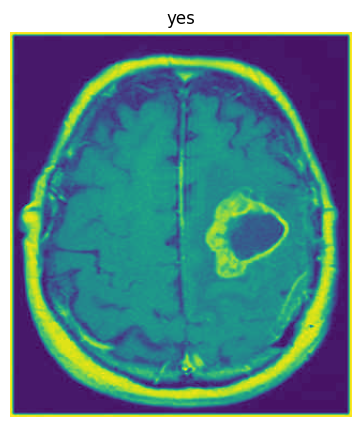

In [14]:
#Visualize random image
plot_random_image(target_folder,train_data.class_names)

# Data preprocessing

In [15]:
# batch data, shuffle again (shuffle=True in image_dataset_from_directory by default) and prefetch for faster load 
train_data = train_data.shuffle(buffer_size=100).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.batch(8).prefetch(tf.data.AUTOTUNE)

# Transfer Learning - Feature extraction model EfficientNet with data augmentation

In [16]:
# Create data augmentation layer
data_aug = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomRotation(0.2)
])

In [17]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False #Freeze model layers

inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = data_aug(inputs)
x = base_model(x, training=False) # set model in inference mode
x = layers.GlobalAveragePooling2D(name='pooling_layer2D')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

In [18]:
# Visualize model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer2D (GlobalAver  (None, 1280)             0         
 agePooling2D)                                                   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 1,281
Non-trainable

In [19]:
#Visualize base model layers (first 20 to save output space)
for layer in base_model.layers[:20]:
    print(layer.name, layer.dtype, layer.trainable)

input_1 float32 False
rescaling float32 False
normalization float32 False
stem_conv float32 False
stem_bn float32 False
stem_activation float32 False
block1a_project_conv float32 False
block1a_project_bn float32 False
block1a_project_activation float32 False
block2a_expand_conv float32 False
block2a_expand_bn float32 False
block2a_expand_activation float32 False
block2a_project_conv float32 False
block2a_project_bn float32 False
block2b_expand_conv float32 False
block2b_expand_bn float32 False
block2b_expand_activation float32 False
block2b_project_conv float32 False
block2b_project_bn float32 False
block2b_drop float32 False


In [20]:
# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [21]:
#Fit the model
model_history = model.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data = val_data,
                              validation_steps=int(0.15 * len(val_data)),
                              callbacks=[model_checkpoint_callback])

Epoch 1/5
12/12 [==============================] - 12s 249ms/step - loss: 0.6459 - accuracy: 0.6404 - val_loss: 0.7059 - val_accuracy: 0.5000
Epoch 2/5
12/12 [==============================] - 2s 125ms/step - loss: 0.5751 - accuracy: 0.6404 - val_loss: 0.6870 - val_accuracy: 0.6250
Epoch 3/5
12/12 [==============================] - 2s 124ms/step - loss: 0.5226 - accuracy: 0.7079 - val_loss: 0.6388 - val_accuracy: 0.6250
Epoch 4/5
12/12 [==============================] - 2s 123ms/step - loss: 0.4680 - accuracy: 0.8315 - val_loss: 0.6314 - val_accuracy: 0.6250
Epoch 5/5
12/12 [==============================] - 2s 145ms/step - loss: 0.4727 - accuracy: 0.8202 - val_loss: 0.6176 - val_accuracy: 0.6250


In [22]:
#Evaluate the model
model_results = model.evaluate(val_data)
model_results

10/10 [==============================] - 0s 18ms/step - loss: 0.4893 - accuracy: 0.8133


[0.48932936787605286, 0.8133333325386047]

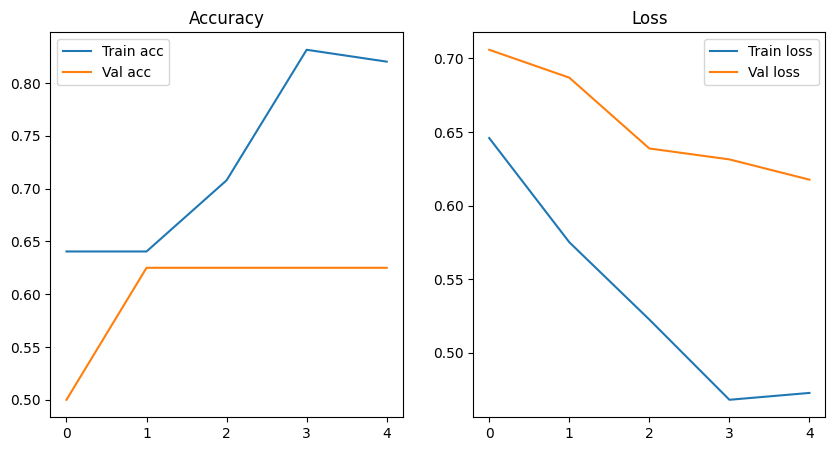

In [23]:
#Plot loss curves
plot_loss_curves(model_history)

# Fine-tune

In [24]:
base_model.trainable=True #Unfreeze all the layers

In [25]:
#Visualize base model layers (first 20 to save output space)
for layer in base_model.layers[:20]:
    print(layer.name, layer.dtype, layer.trainable)

input_1 float32 True
rescaling float32 True
normalization float32 True
stem_conv float32 True
stem_bn float32 True
stem_activation float32 True
block1a_project_conv float32 True
block1a_project_bn float32 True
block1a_project_activation float32 True
block2a_expand_conv float32 True
block2a_expand_bn float32 True
block2a_expand_activation float32 True
block2a_project_conv float32 True
block2a_project_bn float32 True
block2b_expand_conv float32 True
block2b_expand_bn float32 True
block2b_expand_activation float32 True
block2b_project_conv float32 True
block2b_project_bn float32 True
block2b_drop float32 True


In [26]:
# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer=Adam(0.0001),#Lower the learning rate by 10x
                metrics=['accuracy'])

In [27]:
#Fit the model
SAVE_DIR_CHECKPOINTS='ModelCheckpoints/EfficientNetB0_fine_tune'
model_history_fine_tune = model.fit(train_data,
                              epochs=100,
                              steps_per_epoch=len(train_data),
                              validation_data = val_data,
                              validation_steps=int(0.15 * len(val_data)),
                              initial_epoch=model_history.epoch[-1],
                              callbacks=[lr_callback, early_stop, model_checkpoint_callback])

Epoch 5/100
12/12 [==============================] - 15s 485ms/step - loss: 0.4346 - accuracy: 0.8146 - val_loss: 0.4212 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 6/100
12/12 [==============================] - 4s 302ms/step - loss: 0.2641 - accuracy: 0.8820 - val_loss: 0.4708 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 7/100
12/12 [==============================] - 4s 365ms/step - loss: 0.2554 - accuracy: 0.8989 - val_loss: 0.3303 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 8/100
12/12 [==============================] - 4s 307ms/step - loss: 0.1665 - accuracy: 0.9382 - val_loss: 0.6791 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 9/100
12/12 [==============================] - 4s 304ms/step - loss: 0.1796 - accuracy: 0.9213 - val_loss: 0.7341 - val_accuracy: 0.8750 - lr: 1.0000e-04


In [28]:
#Evaluate the fine-tuned model
model_fine_tune_results = model.evaluate(val_data)
model_fine_tune_results

10/10 [==============================] - 0s 15ms/step - loss: 0.2608 - accuracy: 0.9067


[0.26076605916023254, 0.9066666960716248]

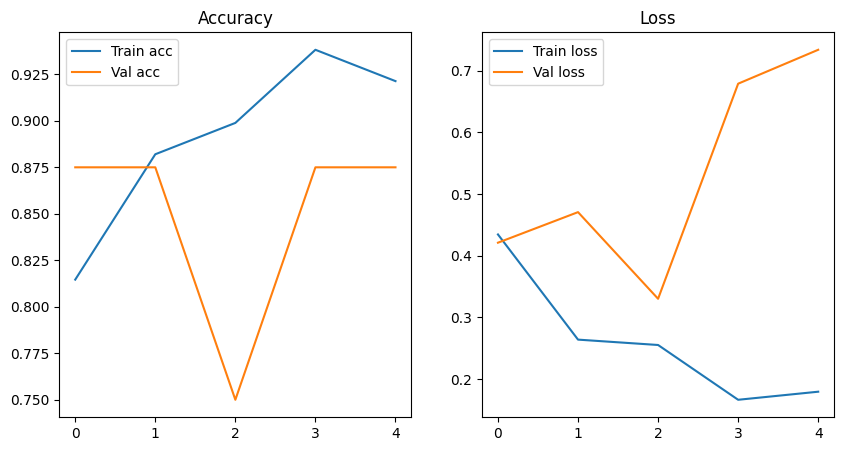

In [29]:
#Plot loss curves
plot_loss_curves(model_history_fine_tune)

In [30]:
#make some predictions with the fine tuned model
model_preds_probs = model.predict(val_data) #This are probabilities 
model_preds = tf.round(model_preds_probs)
model_preds[:10] #first 10 predicted labels

10/10 [==============================] - 1s 13ms/step


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)>

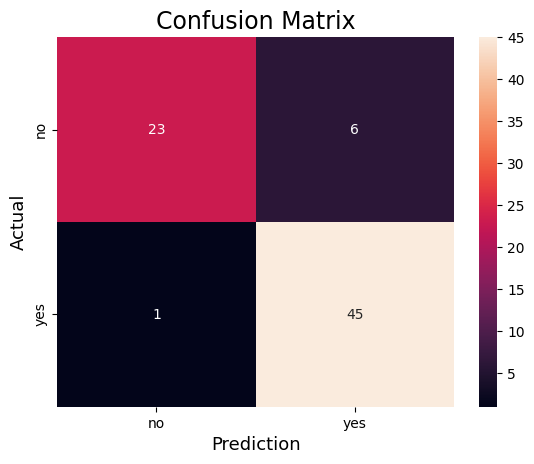

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87        29
         1.0       0.88      0.98      0.93        46

    accuracy                           0.91        75
   macro avg       0.92      0.89      0.90        75
weighted avg       0.91      0.91      0.90        75



In [31]:
cm = confusion_matrix(true_labels, model_preds)
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['no','yes'],
            yticklabels=['no','yes'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
print(classification_report(true_labels, model_preds))